In [2]:
# Analysis of transcription status of a collection
# Compares total occurrence records, records with images, and records missing key data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Set up constants
COLLECTION_PREFIX = 'BRIT' # the string that prepends the digits in a catalogNumber

In [4]:
# load the occurrences file from a Darwin Core Archive
df_occurrences = pd.read_csv("DwC_archive/occurrences.csv", low_memory=False)
# load the images file from a Darwin Core Archive
df_images = pd.read_csv("DwC_archive/images.csv", low_memory=False)

In [5]:
# Merge the occurrence and image records
df_merged = pd.merge(df_occurrences, df_images, how='left', left_on='id', right_on='coreid')

In [6]:
# Make sure the dataset has the number of row and columns you expect
df_merged.shape

(125189, 104)

In [7]:
# Check for duplicates
# This will occur when there is more than one image per occurrence
df_dups = df_merged[df_merged.duplicated(['id'])]
df_dups.shape

(267, 104)

In [8]:
# Save dups if desired
#df_dups.to_csv('duplicates.csv')

In [9]:
# Create column based on collectionNumber
# with the collection prefix removed
df_merged['catalogNumber_num'] = df_merged.apply(lambda row: str(row.catalogNumber).strip(COLLECTION_PREFIX), axis=1)

In [10]:
# Convert the column values to numerical
# TODO find a better way to convert than 'coerce', this can introduce problems or overlook problems
df_merged['catalogNumber_num'] = pd.to_numeric(df_merged['catalogNumber_num'], errors='coerce')

In [11]:
# Fill NA/NaN values with 0
df_merged['catalogNumber_num'] = df_merged['catalogNumber_num'].fillna(0)

In [12]:
# filter bad values if needed
# in the BRIT collection, some catalog numbers were entered incorrectly
# with more than the correct number of digits
df_merged_filtered = df_merged.loc[df_merged['catalogNumber_num'] < 1000000]

In [14]:
# check values of catalogNumber_num
df_merged_filtered['catalogNumber_num'].nlargest(n=10)

92489    741926.0
79109    651148.0
97612    620064.0
95310    618811.0
91179    588534.0
92160    566398.0
93557    558943.0
93553    558942.0
93547    558941.0
93539    558940.0
Name: catalogNumber_num, dtype: float64

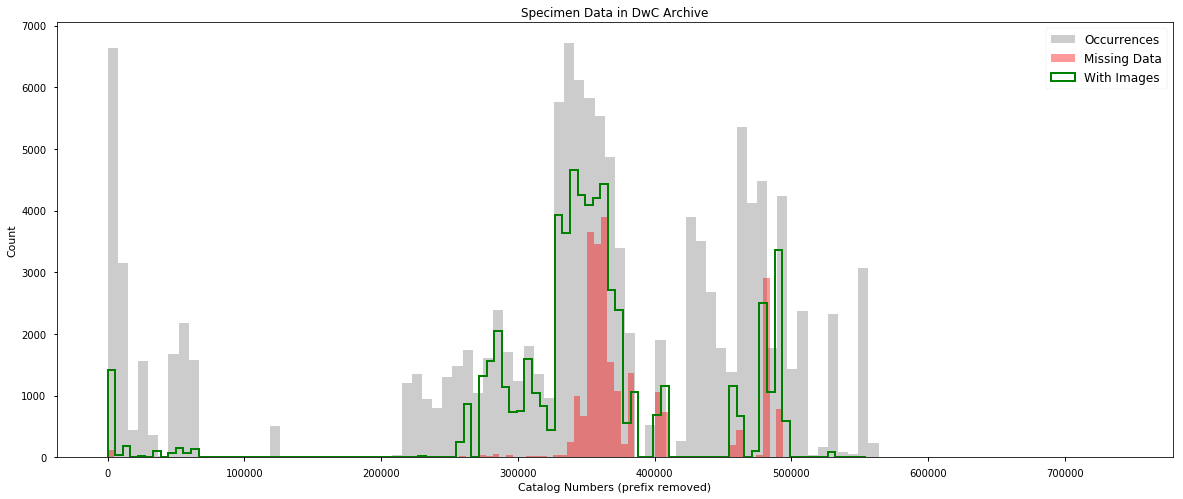

In [16]:
# Graph the results
sns.set_context("notebook")
plt.figure(figsize=(20,8))

# create a Dataframe that will be filtered for the graph
df_plot = df_merged_filtered
# Graph occurrences
sns.distplot(df_plot['catalogNumber_num'], kde=False, bins=100, color='gray', label='Occurrences')
# Find records lacking information
# Records lacking recordedBy
df_null_recordedBy = df_merged_filtered[df_merged_filtered['recordedBy'].isnull()]
# Records lacking recordedBy and scientificName
df_null_sN_and_rB = df_null_recordedBy[df_null_recordedBy['scientificName'].isnull()]
# Graph records lacking data 
df_plot = df_null_sN_and_rB
sns.distplot(df_plot['catalogNumber_num'], kde=False, color='red', bins=100, label='Missing Data')
# Filter occurrences with images
df_plot = df_merged_filtered[df_merged_filtered['accessURI'].notnull()]
# Graph records with images
sns.distplot(df_plot['catalogNumber_num'], kde=False, bins=100, label='With Images', hist_kws={"histtype": "step", "linewidth": 2,"alpha": 1, "color": "green"})
# Add plot information
plt.legend(prop={'size': 12})
plt.title('Specimen Data in DwC Archive')
plt.xlabel('Catalog Numbers (prefix removed)')
plt.ylabel('Count')
# Write out graph image
plt.savefig('catalogNumber_distribution.png', dpi=400)